In [438]:
import json
import plotly
from ipywidgets import interact, interactive, fixed, interact_manual
from pprint import pprint
import plotly.io as pio
pio.renderers.default = "jupyterlab"
 
def simplify_config(game_config: dict) -> dict:
    simple_config = {}
    for config in game_config:
        simple_config[config["NativeClass"]] = {item["ClassName"]: item for item in config["Classes"]}
    return simple_config

CONFIG_LOCATION = "D:\SteamLibrary\steamapps\common\Satisfactory\CommunityResources\Docs\Docs.json"
with open(CONFIG_LOCATION, "r", encoding="utf-16") as f:
    data = f.read()
    BASE_CONFIG = simplify_config(json.loads(data))
    
def standardize(value: str):
    return "_".join(value.replace("-", "_").replace(":", "").split()).lower()

# missing miner, rebar spreadshot
RESOURCE_KEYS = ("Class'/Script/FactoryGame.FGItemDescriptor'", 
                 "Class'/Script/FactoryGame.FGResourceDescriptor'",
                 "Class'/Script/FactoryGame.FGConsumableDescriptor'",
                 "Class'/Script/FactoryGame.FGItemDescriptorBiomass'",
                 "Class'/Script/FactoryGame.FGAmmoTypeProjectile'",
                 "Class'/Script/FactoryGame.FGItemDescriptorNuclearFuel'",
                 "Class'/Script/FactoryGame.FGAmmoTypeInstantHit'",
                 "Class'/Script/FactoryGame.FGAmmoTypeSpreadshot'")

EXTRACTOR_KEYS = (
    "Class'/Script/FactoryGame.FGBuildableResourceExtractor'", 
    "Class'/Script/FactoryGame.FGBuildableFrackingExtractor'"
)

GENERATOR_KEYS = (
     "Class'/Script/FactoryGame.FGBuildableGeneratorFuel'",
     "Class'/Script/FactoryGame.FGBuildableGeneratorGeoThermal'",
     "Class'/Script/FactoryGame.FGBuildableGeneratorNuclear'",
)

# equipment descriptors contain the recipe for automated portable miners

In [439]:
# TODO: make an intermediate config with cleaned up keys
# material/recipe: internal_name: useful info
import itertools

def get_materials(simple_config: dict) -> list[str]:
    resources = []
    for item in itertools.chain.from_iterable((simple_config[key].values() for key in RESOURCE_KEYS)):
        resources.append(standardize(item["mDisplayName"]))
    return resources

def get_recipes(simple_config: dict) -> list[str]:
    pass

def get_extractors():
    pass

def get_generators():
    pass

In [440]:
from abc import ABC
from dataclasses import dataclass, fields, make_dataclass
from enum import Enum, auto
from collections import deque
from typing import Optional
from itertools import zip_longest
import plotly.express as px
import numpy as np
from scipy.optimize import linprog

# TODO: how much of this can be expressed/solved with matrices?

class ConfigurationError(Exception):
    pass

class __MaterialSpec:
    """
    TODO: give this a widget
    """    
    def __add__(self, other):
        if not isinstance(other, type(self)):
            return NotImplemented
        
        result = {}
        for name, value in self:
            result[name] = value + getattr(other, name)
        return type(self)(**result)
    
    def __sub__(self, other):
        if not isinstance(other, type(self)):
            return NotImplemented
        
        result = {}
        for name, value in self:
            result[name] = value - getattr(other, name)
        return type(self)(**result)
    
    def __mul__(self, scalar):
        result = {}
        for name, value in self:
            result[name] = value * scalar 
        return type(self)(**result)
    
    def __iter__(self):
        for f in fields(self):
            yield f.name, getattr(self, f.name)
                       
    def __or__(self, other):
        if isinstance(other, type(self)):
            return type(self)(**{name: value for (name, value), (_, matched_value) in zip(self, other) if matched_value > 0})
        # elif isinstance(other, Material):
        #     return type(self)(**{other.name: getattr(self, other.name)})
        elif isinstance(other, str):
            return type(self)(**{other: getattr(self, other)})
        
        return NotImplemented
    
    def __repr__(self):
        return "\n".join(f"{name}: {value}" for name, value in self if value > 0)

MaterialSpec = make_dataclass("MaterialSpec", [(mat, float, 0) for mat in get_materials(BASE_CONFIG)], bases=(__MaterialSpec,), repr=False)
    
class Recipe:
    name: str
    # TODO: duration: float
    
    def __init__(self, name: str, ingredients: MaterialSpec, products: MaterialSpec):
        self.ingredients = ingredients
        self.products = products
        self.name = name
        
    def __add__(self, material_spec: MaterialSpec):
        return material_spec + self.products - self.ingredients
    
    def __radd__(self, material_spec: MaterialSpec):
        return self + material_spec
    
    def __rsub__(self, material_spec: MaterialSpec):
        return material_spec + self.ingredients - self.products
    
    def __mul__(self, scalar: float):
        """
        Scale up this recipe
        """
        return type(self)(self.name, self.ingredients * scalar, self.products * scalar)
    
    def __rtruediv__(self, material_spec: MaterialSpec):
        """
        Get the number of iterations of this recipe that can be produced from the given material_spec
        """
        return min(getattr(material_spec, name) / value for name, value in self.ingredients if value > 0)
    
    def __repr__(self):
        ingredients = " ".join(repr(self.ingredients).splitlines())
        products = " ".join(repr(self.products).splitlines())
                
        return f"{ingredients} >> {products}"
        
        
class Machine(ABC):
    # TODO: don't subclass machines, just take a category argument and set parameters from config/recipe. It doesn't matter what the number of outputs is
    
    # TODO: weakref these
    input_producers: dict["Machine", str]
    output_consumers: dict["Machine", str]
    
    power_consumption: float
    power_production: float
    
    clock_speed: float # TODO
    _consumption_exponent: float # TODO
    inputs: int
    outputs: int
    color: str
    
    _color_generator = iter(px.colors.qualitative.Dark24)
    
    def __init__(self, recipe: Recipe):
        inputs = sum(material > 0 for _, material in recipe.ingredients)
        outputs = sum(material > 0 for _, material in recipe.products)
        self.input_producers = {}
        self.output_consumers = {}
        
        if inputs != self.inputs or outputs != self.outputs:
            raise ConfigurationError(f"{self.__class__} must have {self.inputs} inputs and {self.outputs} outputs")
            
        self.recipe = recipe
        
    def __init_subclass__(cls, skip_color=False):
        if not skip_color:
            cls.color = next(cls._color_generator)
        
    def __str__(self):
        return f"<{self.__class__.__name__}: {self.recipe}>"
        
    def __repr__(self):
        return str(self)
        
    def __rshift__(self, material_spec: MaterialSpec):
        """
        Solve for inputs
        Recipe >> MaterialSpec
        """
        # TODO: what should the inverse of div be?
        scale = max(getattr(material_spec, name) / value for name, value in self.recipe.products if value > 0)
        scaled = self.recipe * scale
        return material_spec - scaled
    
    def __lshift__(self, material_spec: MaterialSpec):
        """
        Solve for outputs
        Recipe << MaterialSpec
        """
        scale = material_spec / self.recipe
        scaled = self.recipe * scale
        return material_spec + scaled
        
    def __rrshift__(self, material_spec: MaterialSpec):
        """
        Solve for inputs
        MaterialSpec << Recipe
        """
        return self << material_spec
    
    def __rlshift__(self, material_spec: MaterialSpec):
        """
        Solve for outputs
        MaterialSpec >> Recipe
        """
        return self >> material_spec
        
    def has_input(self, material: str):
        return getattr(self.recipe.ingredients, material) > 0
    
    def has_output(self, material: str):
        return getattr(self.recipe.products, material) > 0
    
    # TODO: there's some serious confusion of responsibilities between this and recipe
    def products(self):
        return [product for product, value in self.recipe.products if value > 0]
    
    def ingredients(self):
        return [ingredient for ingredient, value in self.recipe.ingredients if value > 0]
    
    def bind(self, other: "Machine", material: str):
        """
        Verify that there is a matching input-output pair for these two machines
        
        # TODO: can only handle binding one output to a given machine
        """
        if self.has_output(material) and other.has_input(material):
            other.input_producers[self] = material
            self.output_consumers[other] = material
        elif self.has_input(material) and other.has_output(material):
            self.input_producers[other] = material
            other.output_consumers[self] = material
        else:
            raise ConfigurationError(f"{self} and {other} do not have a matching input and output.")
            
        return self
    
    @staticmethod
    def autobind(machines: list["Self"]):
        for i, machine in enumerate(machines):
            for other_machine in machines[i:]:
                for ingredient in machine.ingredients():
                    if other_machine.has_output(ingredient):
                        machine.bind(other_machine, ingredient)
                for product in machine.products():
                    if other_machine.has_input(product):
                        machine.bind(other_machine, product)
        

def dataclass_to_list(cd: "dataclass"):
    return [getattr(cd, f.name) for f in sorted(fields(cd), key=lambda f: f.name)]
    

In [441]:
class Process:
    """
    TODO: power
    """
    scale: int
    power: float = 0
    process_root: Machine
    input_materials: MaterialSpec
    output_materials: MaterialSpec
    
    def __init__(self, process_root: Machine, registry, scale: float=1):
        self.process_root = process_root
        self.scale = scale
        self.input_materials = process_root.recipe.ingredients * scale
        self.output_materials = process_root.recipe.products * scale
        
        # TODO: this is terrible
        self.process_registry = registry
        registry[process_root] = self
        
        
    @classmethod
    def from_outputs(cls, target_output: MaterialSpec, machines: list[Machine], include_power=False):
        """
        Builds a process tree from a list of machines
        
        TODO: co-optimize generation, use less than constraint, multiple gen/load by -1 to ensure excess consumption
        TODO: allow surplos
        """
        output = Aggregator(Recipe("output", target_output, target_output))
        nodes = deque([output])
        visited = set()
        registry = {}

        # collect possible nodes in tree
        while len(nodes):
            current_node = nodes.popleft()
            visited.add(current_node)
            
            for machine in machines:
                for ingredient in current_node.ingredients():
                    if machine.has_output(ingredient):
                        if machine not in visited:
                            nodes.append(machine)
        
        visited = list(visited)
        costs = [1 for _ in visited] # TODO: pre-process cost per recipe
        output_equals = dataclass_to_list(target_output)
        
        material_constraints = np.array([dataclass_to_list(m.recipe.products - m.recipe.ingredients) for m in visited]).T
        
        if include_power:
            A_ub = [m.power_consumption - m.power_production for m in visited]
            b_ub = [0]
            solution = linprog(c=costs, A_eq=material_constraints, b_eq=output_equals, A_ub=A_ub, b_ub=b_ub)
        else:
            solution = linprog(c=costs, A_eq=material_constraints, b_eq=output_equals)
        
        for m, s in zip(visited, solution.x.round(4)):
            cls(m, registry, s)
                
        cls(output, registry, 1)
            
        return registry[output]
    
    
    @classmethod
    def from_inputs(cls, available_materials, target_output, machines, generators=None):
        """
        NOTE: if extractors are passed in here, this optimization is unbounded, since extractors are currently modelled as requiring no resources
              to output their expected output. This may be why extractors in the config have a balanced in and output rate. In the case of this
              problem, however, the optimizer will ignore extractors since consuming materials directly is equivalent.
              FIXME: this can be addressed by adding an additional constraint on producers/extractors. May be trick for intermediate products
        """
        inputs = Aggregator(Recipe("input", available_materials, available_materials))
        nodes = deque([inputs])
        visited = set()
        registry = {}

        # collect possible nodes in tree
        while len(nodes):
            current_node = nodes.popleft()
            visited.add(current_node)
            for machine in machines:
                for product in current_node.products():
                    # TODO: this works, for unknown reasons. Without this, solution includes extraneous recipes, seemingly
                    # to balance consumption
                    if machine.has_input(product):
                        if machine not in visited:
                            nodes.append(machine)
        
        visited = list(visited)
        
        # FIXME: this setup of getattrs/weird loop order is heinous, even by the standards of this project
        costs = np.array([*[sum((getattr(target_output, mat) > 0) * getattr(m.recipe.ingredients - m.recipe.products, mat) for mat in [*m.products(), *m.ingredients()]) for m in visited], *[.001 for _ in visited]])
        
        connect_eq_constraints = [[(j == i % len(visited)) * (1 - 2*(i // len(visited))) for i, _ in enumerate([*visited, *visited])] for j, _ in enumerate(visited)]
        connect_eq_bounds = [0 for _ in range(len(visited))]
        
        production_matrix = np.array([dataclass_to_list(m.recipe.ingredients - m.recipe.products) for m in visited]).T
        production_matrix = np.concatenate((production_matrix, np.zeros_like(production_matrix)), axis=1)
        
        production_amounts = dataclass_to_list(target_output)
        production_indices, *_ = np.nonzero(production_amounts)
        
        for mat_1_idx, mat_2_idx in zip(production_indices[:-1], production_indices[1:]):
            ratio = production_amounts[mat_1_idx] / production_amounts[mat_2_idx]
            connect_eq_constraints.append(-1*production_matrix[mat_1_idx, :] + ratio * production_matrix[mat_2_idx, :])
            connect_eq_bounds.append(0)
            
        connect_eq_constraints = np.array(connect_eq_constraints)
        connect_eq_bounds = np.array(connect_eq_bounds)
        
        
        # make products hove positive value, require consumption to be <= available
        output_bounds = np.array([*[material - .001 * (i in production_indices) for i, material in enumerate(dataclass_to_list(available_materials))]])                        

        solution = linprog(c=costs, A_ub=production_matrix, b_ub=output_bounds, A_eq=connect_eq_constraints, b_eq=connect_eq_bounds)
                
        for m, s in zip(visited, solution.x.round(4)):
            cls(m, registry, s)
                
        cls(inputs, registry, 1)
        
        return registry[inputs]

In [442]:
class VariableOutputMachine(Machine, skip_color=True):
        
    def __init__(self, recipe: Recipe):
        self.outputs = min(sum(material > 0 for _, material in recipe.products), self.outputs)
        
        super().__init__(recipe)
        
class VariableInputMachine(Machine, skip_color=True):
        
    def __init__(self, recipe: Recipe):
        self.inputs = min(sum(material > 0 for _, material in recipe.ingredients), self.inputs)
        
        super().__init__(recipe)
                                                                                  
    
class Constructor(Machine):
    power_consumption = 4
    inputs = 1
    outputs = 1
    
    
class Assembler(Machine):
    power_consumption = 15
    inputs = 2
    outputs = 1
    
    
class Manufacturer(VariableInputMachine):
    power_consumption = 55
    inputs = 4
    outputs = 1
    
    
class Smelter(Machine):
    power_consumption = 4
    inputs = 1
    outputs = 1
    
    
class Foundry(Machine):
    power_consumption = 16 
    inputs = 2
    outputs = 1
    
    
class Packager(VariableOutputMachine, VariableInputMachine):
    power_consumption = 10
    inputs = 2
    outputs = 2
    
    
class Refinery(VariableOutputMachine, VariableInputMachine):
    power_consumption = 30
    inputs = 2
    outputs = 2

    
class Extractor(Machine):
    # TODO: different extractor types have different consumption
    power_consumption = 10
    inputs = 0
    outputs = 1
    
    
class Blender(VariableOutputMachine, VariableInputMachine):
    # TODO: power consumption varies by recipe
    power_consumption = 1500
    inputs = 4
    outputs = 2
    
    
class Aggregator(Machine):
    """
    Special class to join disjoint trees so that every process can be expressed as a tree, 
    regardless of desired outputs. Can be used, for example, to represent a factory floor as a 'Machine'
    """
    power_consumption = 0
    def __init__(self, recipe: Recipe):
        self.inputs = sum(material > 0 for _, material in recipe.ingredients)
        self.outputs = sum(material > 0 for _, material in recipe.products)
        super().__init__(recipe)
        
    
class ParticleAccelerator(VariableInputMachine):
    power_consumption = 300
    inputs = 3
    outputs = 1
    
# TODO: get resource cost for proposed factory (buildings)

In [443]:
import re
from dataclasses import dataclass, field

machine_mapping = {"/Game/FactoryGame/Buildable/Factory/AssemblerMk1/Build_AssemblerMk1.Build_AssemblerMk1_C": Assembler, 
 "/Game/FactoryGame/Buildable/Factory/ManufacturerMk1/Build_ManufacturerMk1.Build_ManufacturerMk1_C": Manufacturer, 
 "/Game/FactoryGame/Buildable/Factory/SmelterMk1/Build_SmelterMk1.Build_SmelterMk1_C": Smelter,
 "/Game/FactoryGame/Buildable/Factory/ConstructorMk1/Build_ConstructorMk1.Build_ConstructorMk1_C": Constructor, 
 "/Game/FactoryGame/Buildable/Factory/FoundryMk1/Build_FoundryMk1.Build_FoundryMk1_C": Foundry,
 "/Game/FactoryGame/Buildable/Factory/HadronCollider/Build_HadronCollider.Build_HadronCollider_C": ParticleAccelerator,
 "/Game/FactoryGame/Buildable/Factory/Blender/Build_Blender.Build_Blender_C": Blender,
 "/Game/FactoryGame/Buildable/Factory/Packager/Build_Packager.Build_Packager_C": Packager,
 "/Game/FactoryGame/Buildable/Factory/OilRefinery/Build_OilRefinery.Build_OilRefinery_C": Refinery}

@dataclass
class Machines:
    alternates: list[Machine] = field(default_factory=list)
    core: list[Machine] = field(default_factory=list)
    fluid_extractors: list[Machine] = field(default_factory=list)
    extractors_mk1: list[Machine] = field(default_factory=list)
    extractors_mk2: list[Machine] = field(default_factory=list)
    extractors_mk3: list[Machine] = field(default_factory=list)
    
    
# TODO: keep dict of recipes, store collections of core/alternate as strings so that available recipes can be specified as a collection of strings
# TOODO: use recipes config key, rather than all of this nonsense--retain class name to material name
# FIXME: smelters are 1:1
# FIXME: add generators
def make_recipes(simple_config: dict, machine_mapping: dict[str, Machine]) -> list:
    resource_capture_group = r".*?\.(\w+).*?"
    ingredients_pattern = rf"\(ItemClass={resource_capture_group},Amount=(\d+)\)"
    machines_pattern = fr"({'|'.join(re.escape(m) for m in machine_mapping.keys())})"
    known_crafters = ("Smelter", "Manufacturer", "Assembler", "Packager", "Refinery", "Collider", "Foundry", "Blender", "Constructor")
    
    machines = Machines()
    material_config = {}
    for key in RESOURCE_KEYS:
        material_config.update(simple_config[key])

    for config in simple_config["Class'/Script/FactoryGame.FGRecipe'"].values():
        machine = re.search(machines_pattern, config["mProducedIn"])
        
        if machine is None:
            continue

        machine = machine_mapping[machine[0]]
            
        # TODO: convert resources to friendly names
        try:
            ingredients = {standardize(material_config[name]["mDisplayName"]): float(amt) / 1000 if material_config[name]["mForm"] in ["RF_LIQUID", "RF_GAS"] else float(amt) for name, amt in re.findall(ingredients_pattern, config["mIngredients"])}
            products = {standardize(material_config[name]["mDisplayName"]): float(amt) / 1000 if material_config[name]["mForm"] in ["RF_LIQUID", "RF_GAS"] else float(amt) for name, amt in re.findall(ingredients_pattern, config["mProduct"])}
            if "alternate" in config["FullName"].lower():
                machines.alternates.append(machine(Recipe(standardize(config["mDisplayName"]), MaterialSpec(**ingredients), MaterialSpec(**products)) * (60 / float(config["mManufactoringDuration"]))))
            else:
                machines.core.append(machine(Recipe(standardize(config["mDisplayName"]), MaterialSpec(**ingredients), MaterialSpec(**products)) * (60 / float(config["mManufactoringDuration"]))))
                                
        except Exception as e:
            print(f"missing: {e}")
            print()
            
    def get_production_rate(config):
        return (60 / float(config["mExtractCycleTime"])) * float(config["mItemsPerCycle"])
            
    # FIXME: I think this qualifies as a mess
    for key in EXTRACTOR_KEYS:
        for extractor in simple_config[key].values():
            if "RF_SOLID" in extractor["mAllowedResourceForms"]:
                for material in map(lambda x:standardize(material_config[x]["mDisplayName"]), simple_config["Class'/Script/FactoryGame.FGResourceDescriptor'"].keys()):
                    if "mk1" in  extractor["ClassName"].lower():
                        machines.extractors_mk1.append(Extractor(Recipe(material, MaterialSpec(), MaterialSpec(**{material: get_production_rate(extractor)}))))
                    elif "mk2" in  extractor["ClassName"].lower():
                        machines.extractors_mk2.append(Extractor(Recipe(material, MaterialSpec(), MaterialSpec(**{material: get_production_rate(extractor)}))))
                    elif "mk3" in  extractor["ClassName"].lower():
                        machines.extractors_mk3.append(Extractor(Recipe(material, MaterialSpec(), MaterialSpec(**{material: get_production_rate(extractor)}))))
            elif "RF_LIQUID" in extractor["mAllowedResourceForms"] or "RF_GAS" in extractor["mAllowedResourceForms"]:
                for material in map(lambda x: standardize(material_config[re.search(resource_capture_group, x)[1]]["mDisplayName"]), extractor["mAllowedResources"].strip("()").split(",")):
                    machines.fluid_extractors.append(Extractor(Recipe(material, MaterialSpec(), MaterialSpec(**{material: get_production_rate(extractor) / 1000}))))
        
        
    return machines

In [444]:
import igraph
from igraph import Graph, EdgeSeq
import itertools
import plotly.graph_objects as go
import os
from textwrap import dedent
import numpy as np

import math

def make_hover_label(process: Process):
    return dedent(f"""
    {process.process_root.__class__.__name__}<br>
    Recipe: {process.process_root.recipe.name}<br>
    Scale: {process.scale}
    """)


# TODO: show machine types in legend
def plot_process(process: Process, layout=Graph.layout_auto):
    ordered_vertices = [m for m in process.process_registry.values() if m.scale > 0]
    n_vertices = len(ordered_vertices)
    
    edges = [(ordered_vertices.index(process.process_registry[other]), ordered_vertices.index(self)) for self in ordered_vertices for other in self.process_root.input_producers if process.process_registry[other] in ordered_vertices]
    breakpoint()

    G = Graph(n_vertices, edges)
    layout = G.layout(layout)
    Xn, Yn = list(zip(*layout))
    edge_coords = itertools.chain.from_iterable([[(Xn[n], Yn[n]) for n in e] + [(None, None)] for e in edges])
    Xe, Ye = list(zip(*edge_coords))
    
    max_scale = max(n.scale for n in ordered_vertices)
    point_scale = 20
    point_sizes = [(math.tanh(n.scale  / max_scale) + 1) * point_scale for n in ordered_vertices]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
                       x=Xe,
                       y=Ye,
                       mode='lines+markers',
                       hoverinfo='none',
                       line_shape='spline',
                       marker=dict(
                            symbol="arrow-wide",
                            size=10,
                            color="black",
                            angleref="previous",
                            standoff=point_scale//2
                        ),
                        showlegend=False
                    ),
                    
                 )

    fig.add_trace(go.Scatter(x=Xn,
                      y=Yn,
                      mode='markers',
                      marker=dict(symbol='circle-dot',
                                  size=point_sizes,
                                  color=[m.process_root.color for m in ordered_vertices],
                                ),
                      text=[make_hover_label(v) for v in ordered_vertices],
                      hovertemplate="%{text}<extra></extra>",
                      showlegend=False,
                      )
                 )

    # TODO: better sizing
    fig.update_layout(
        autosize=True,
        xaxis= {
            'showgrid': False, # thin lines in the background
            'zeroline': False, # thick line at x=0
            'visible': False,  # numbers below
        },
        yaxis= {
            'showgrid': False, # thin lines in the background
            'zeroline': False, # thick line at x=0
            'visible': False,  # numbers below
        },
        height=1000
    )

    fig.show()
    
    
def plot_sankey(process: Process):
    ordered_vertices = [m for m in process.process_registry.values() if m.scale > 0]
    n_vertices = len(ordered_vertices)
    
    edges = [(ordered_vertices.index(process.process_registry[other]), ordered_vertices.index(self)) for self in ordered_vertices for other in self.process_root.input_producers if process.process_registry[other] in ordered_vertices]
    source, target = zip(*edges)
    # TODO: get the bound resource and multiply by the source scale
    
    def get_materials_for_link(start: int, end: int, vertices: list[Process]):
        start_process = vertices[start]
        end_process = vertices[end]
        bound_material = start_process.process_root.output_consumers[end_process.process_root]
        return bound_material, (getattr(end_process.process_root.recipe.ingredients, bound_material) * end_process.scale)
    
    labels, weights = zip(*[get_materials_for_link(start, end, ordered_vertices) for (start, end) in edges])
    
    fig = go.Figure()
    fig.add_trace(
        go.Sankey(
            node=dict(
                label = [f"{v.process_root.__class__.__name__}: {v.process_root.recipe.name}" for v in ordered_vertices]
            ),
            link=dict(
                source=source,
                target=target,
                value=weights,
                label=labels
            )
        )
    )
    fig.show()

# TODO: use plotly tables and link rows to scatter/sankey nodes
def make_row(values: list[str]):
    return "<tr>" + "".join([f"<td>{v}</td>" for v in values]) + "</tr>"

def make_table(headers: list[str], values: list[list[str]]):
    header = make_row(headers)
    rows = "\n".join([make_row(row) for row in values])
    
    return dedent(f"""
    <table>
    <thead>
    {header}
    </thead>
    <tbody>
    {rows}
    </tbody>
    </table>""")

def recipe_summary(process: Process):
    headers = ["Machine Type", "Count", "Recipe", "Ingredients", "Products"]
    rows = []
    for process in process.process_registry.values():
        if process.scale > 0:
            rows.append([process.process_root.__class__.__name__,
                         process.scale,
                         process.process_root.recipe.name,
                         "<br>".join([f"{name}: {value * process.scale:.2f}" for name, value in process.process_root.recipe.ingredients if value > 0]),
                         "<br>".join([f"{name}: {value * process.scale:.2f}" for name, value in process.process_root.recipe.products if value > 0]),
                        ])
                     
    return make_table(headers, rows)
    

def total_power(process: Process):
    total =  sum(p.scale * p.process_root.power_consumption for p in filter(lambda p: p.scale > 0, process.process_registry.values()))
    print(f"Total Power: {total}")


In [445]:
from IPython.core.display import display, HTML

def factory_plan(target):
    available_machines = make_recipes(BASE_CONFIG, machine_mapping)
    # stator?
    #target_product = MaterialSpec(steel_beam=5, encased_industrial_beam=5, modular_frame=2, heavy_modular_frame=2)
    available_machines = [*available_machines.core,
                                     *available_machines.extractors_mk1,
                                     *available_machines.fluid_extractors]
    Machine.autobind(available_machines)
    

    solution = Process.from_outputs(target, 
                                    available_machines
                                    )
    
    plot_process(solution, Graph.layout_reingold_tilford)
    plot_sankey(solution)
    display(HTML(recipe_summary(solution)))
    total_power(solution)
    return solution

missing: 'BP_ItemDescriptorPortableMiner_C'



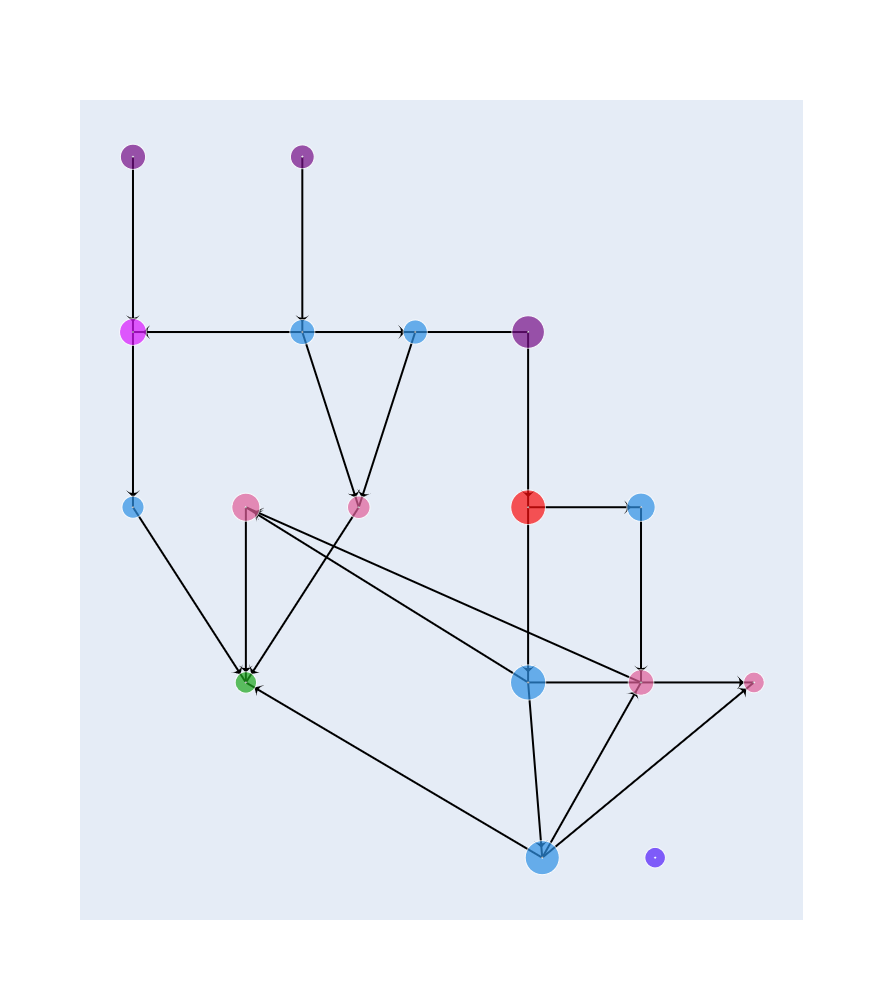

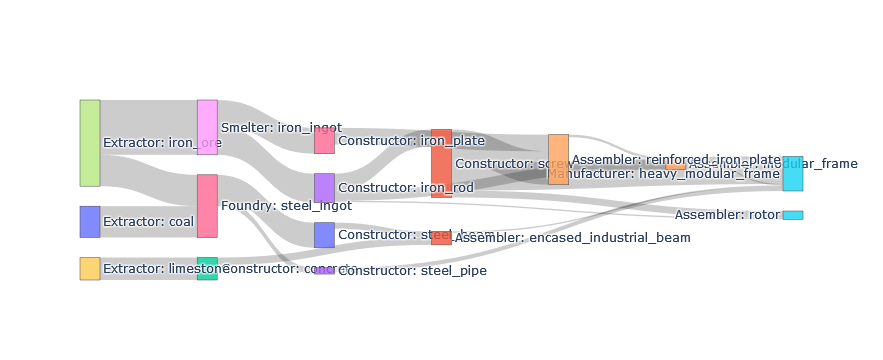

Machine Type,Count,Recipe,Ingredients,Products
Extractor,9.4083,coal,,coal: 564.50
Constructor,30.625,screw,iron_rod: 306.25,screw: 1225.00
Constructor,9.0,concrete,limestone: 405.00,concrete: 135.00
Constructor,3.75,steel_pipe,steel_ingot: 112.50,steel_pipe: 75.00
Assembler,15.0,modular_frame,iron_rod: 180.00reinforced_iron_plate: 45.00,modular_frame: 30.00
Manufacturer,2.5,heavy_modular_frame,screw: 500.00modular_frame: 25.00encased_industrial_beam: 25.00steel_pipe: 75.00,heavy_modular_frame: 5.00
Foundry,12.5444,steel_ingot,coal: 564.50iron_ore: 564.50,steel_ingot: 564.50
Extractor,25.8458,iron_ore,,iron_ore: 1550.75
Smelter,32.875,iron_ingot,iron_ore: 986.25,iron_ingot: 986.25
Extractor,6.75,limestone,,limestone: 405.00


Total Power: 1755.6346


In [446]:
# total production
target_product = MaterialSpec(iron_rod=10, iron_plate=10, reinforced_iron_plate=5, rotor=5,
                                  steel_beam=5, encased_industrial_beam=2, modular_frame=5, heavy_modular_frame=5)

factory_plan(target_product)

missing: 'BP_ItemDescriptorPortableMiner_C'



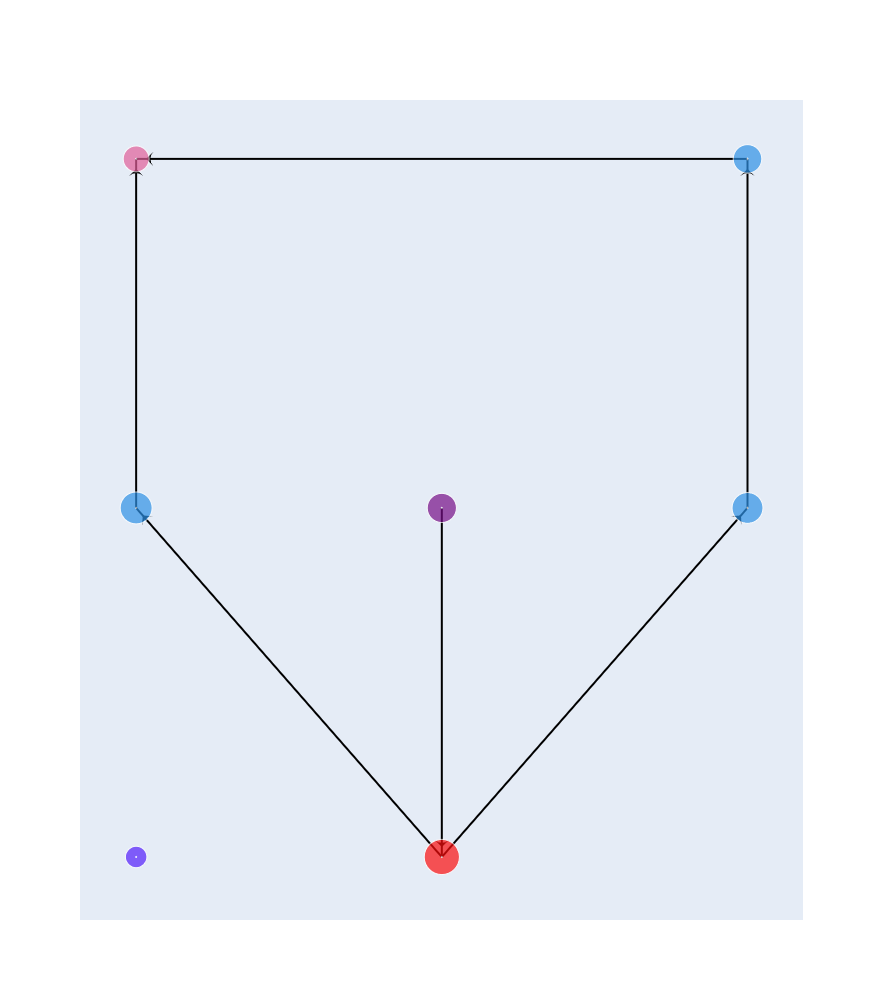

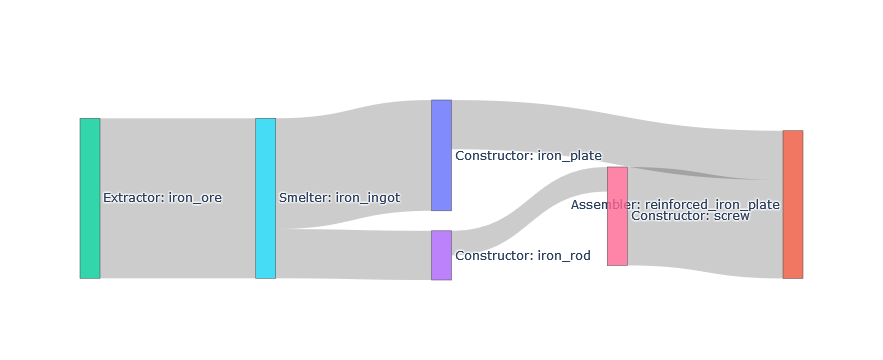

Machine Type,Count,Recipe,Ingredients,Products
Constructor,9.0,iron_plate,iron_ingot: 270.00,iron_plate: 180.00
Assembler,4.0,reinforced_iron_plate,screw: 240.00iron_plate: 120.00,reinforced_iron_plate: 20.00
Extractor,6.5,iron_ore,,iron_ore: 390.00
Constructor,8.0,iron_rod,iron_ingot: 120.00,iron_rod: 120.00
Aggregator,1,output,iron_rod: 60.00iron_plate: 60.00reinforced_iron_plate: 20.00,iron_rod: 60.00iron_plate: 60.00reinforced_iron_plate: 20.00
Smelter,13.0,iron_ingot,iron_ore: 390.00,iron_ingot: 390.00
Constructor,6.0,screw,iron_rod: 60.00,screw: 240.00


Total Power: 269.0


In [447]:
# small iron factory
target_product = MaterialSpec(iron_rod=60, iron_plate=60, reinforced_iron_plate=20)

factory_plan(target_product)

missing: 'BP_ItemDescriptorPortableMiner_C'



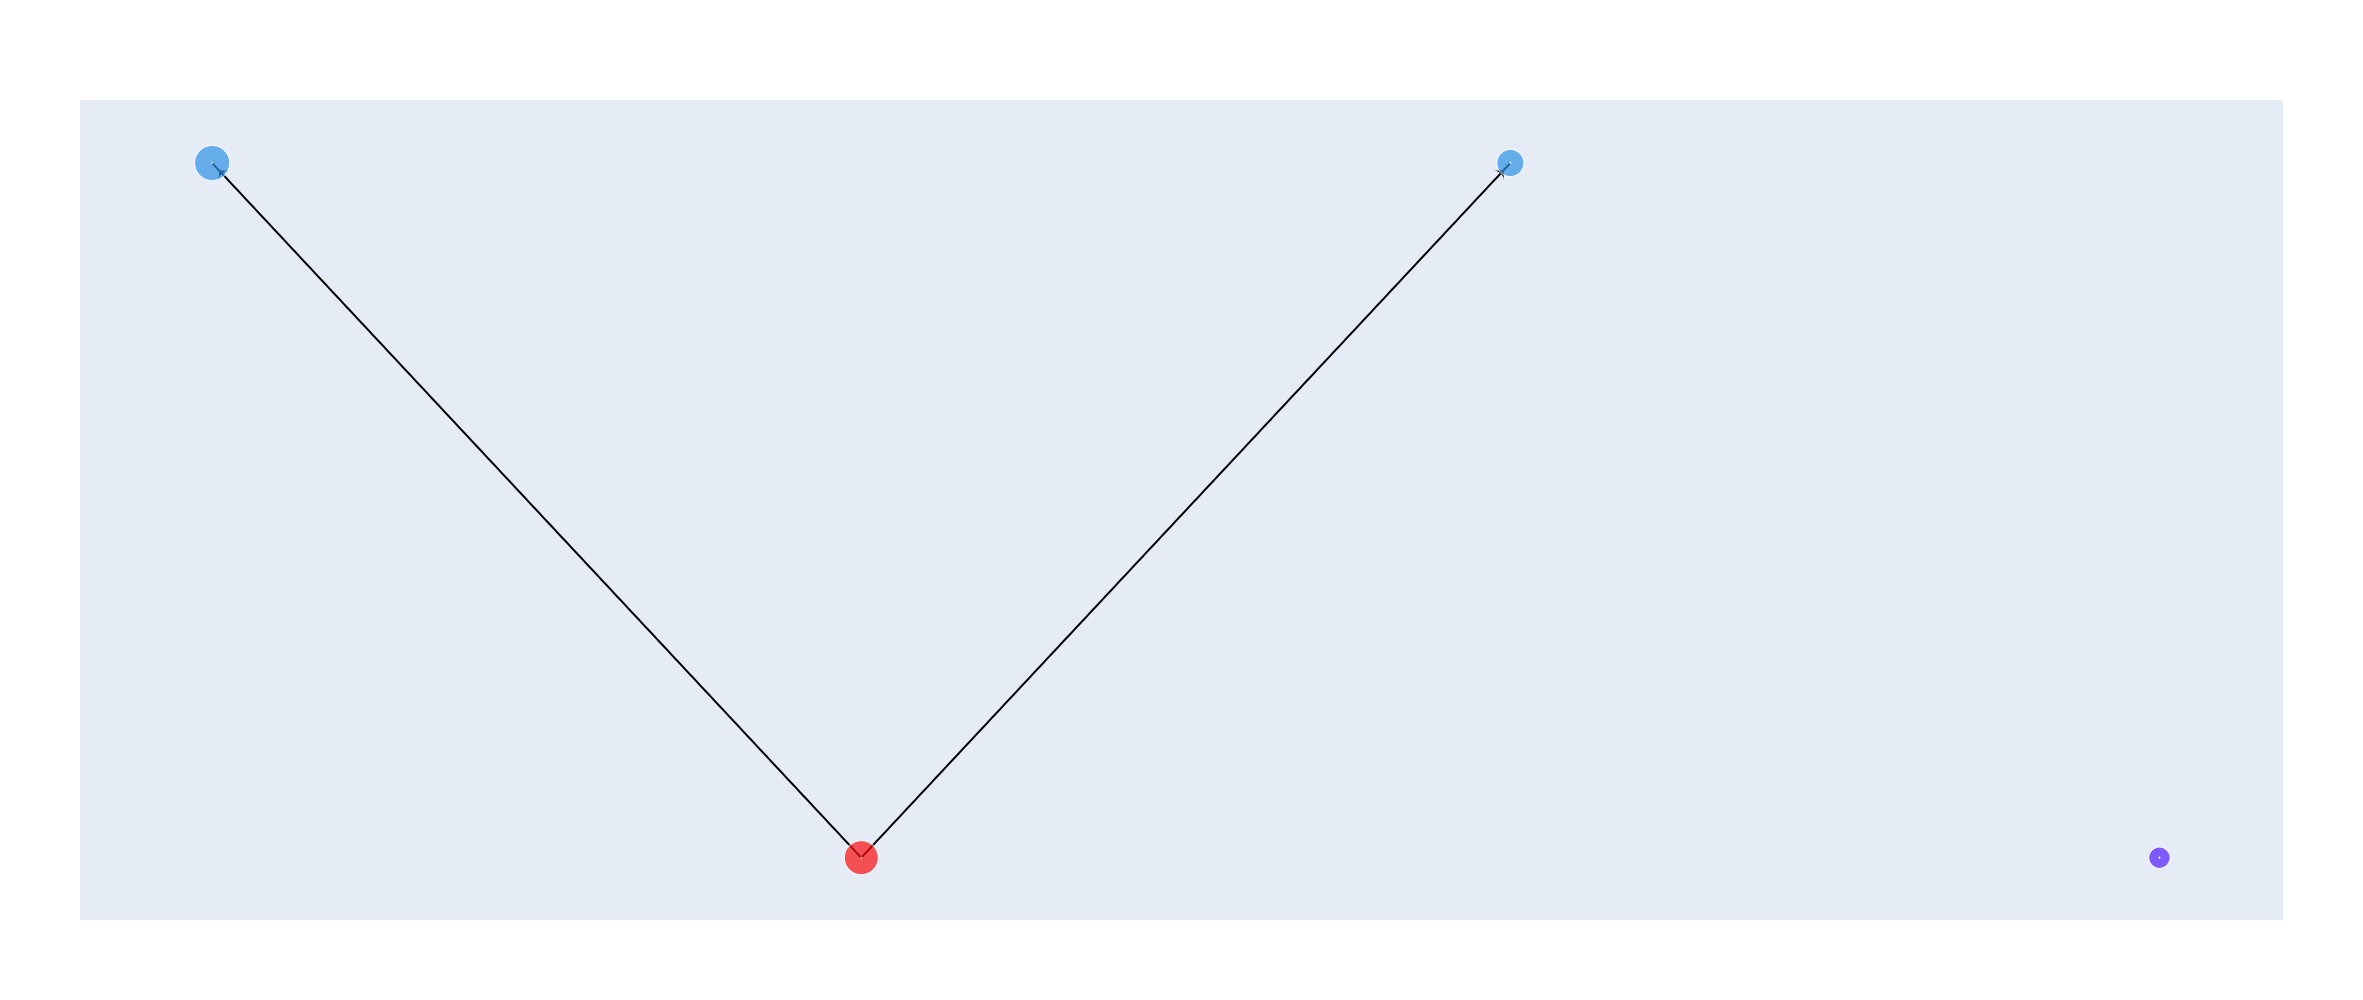

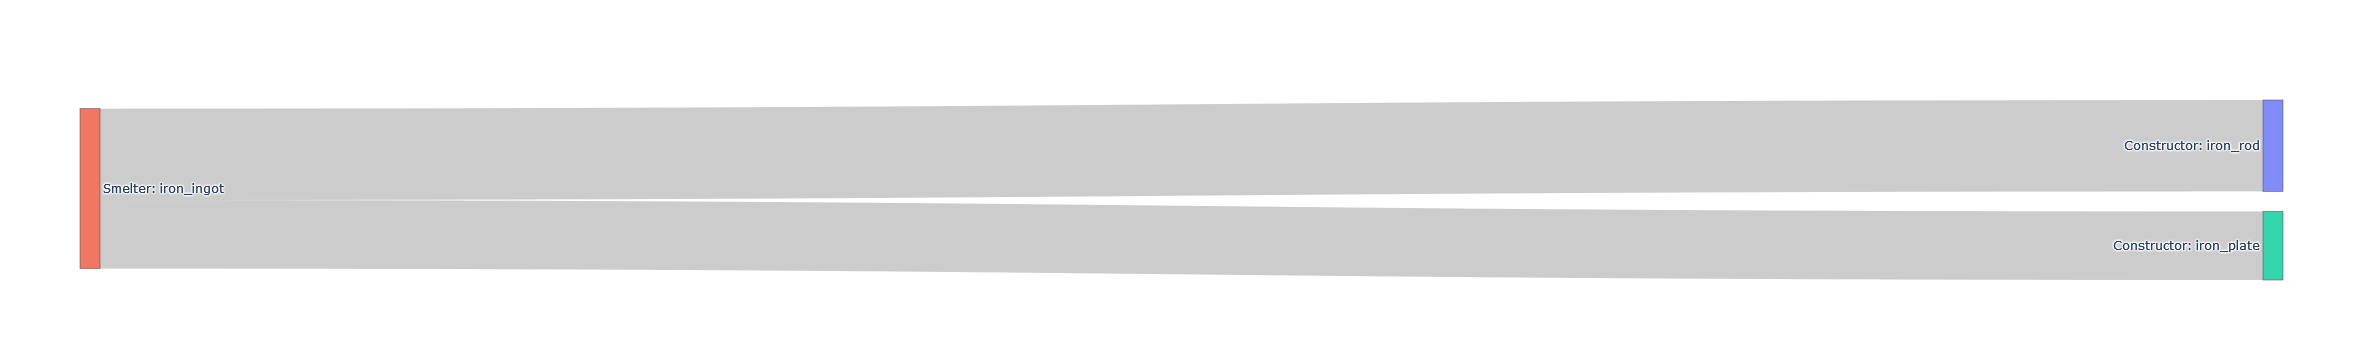

Machine Type,Count,Recipe,Ingredients,Products
Constructor,13.7143,iron_rod,iron_ingot: 205.71,iron_rod: 205.71
Smelter,12.0,iron_ingot,iron_ore: 360.00,iron_ingot: 360.00
Constructor,5.1429,iron_plate,iron_ingot: 154.29,iron_plate: 102.86
Aggregator,1,input,iron_ore: 360.00,iron_ore: 360.00


In [449]:
available_machines = make_recipes(BASE_CONFIG, machine_mapping)
available_machines = [*available_machines.core]
Machine.autobind(available_machines)

target_product = MaterialSpec(iron_plate=1, iron_rod=2)
target_available = MaterialSpec(iron_ore=360)
solution = Process.from_inputs(target_available,
                               target_product,
                               available_machines)

plot_process(solution, Graph.layout_reingold_tilford)
plot_sankey(solution)
display(HTML(recipe_summary(solution)))

In [450]:
# small steel factory

In [451]:
# big steel factory